<a href="https://colab.research.google.com/github/bohdanhlovatskyi/sad_cat/blob/main/Conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

filter == kernel

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
import numpy as np
import pandas as pd
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

DATA_READY = True

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.listdir("drive/MyDrive/Colab Notebooks/conv")

['training_data.npy', 'Conv.ipynb']

In [ ]:
data_path = "drive/MyDrive/Colab Notebooks/conv/training_data.npy"

In [ ]:
class Preprocessor:
    IMG_SIZE = 50
    CATS = "kagglecatsanddogs_3367a/PetImages/Cat"
    DOGS = "kagglecatsanddogs_3367a/PetImages/Dog"
    LABELS = {CATS: 0, DOGS: 1}
    
    training_data = []
    catcount, dogcount = 0, 0
    
    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label, f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])
            
                    if label == self.CATS:
                        self.catcount += 1
                    if label == self.DOGS:
                        self.dogcount += 1
                except Exception as e:
                    # print(e)
                    continue
                    
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print("Cats: ", self.catcount)
        print("Dogs: ", self.dogcount)


In [ ]:
if not DATA_READY:  
  p = Preprocessor()
  p.make_training_data()

train = np.load(data_path, allow_pickle = True)
train.shape

(19697, 2)

[1. 0.]


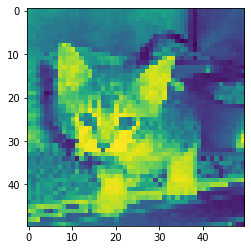

In [ ]:
print(train[0][1])
plt.imshow(train[0][0])

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # input, num of featuers, kernel size
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        self.adapt = nn.AdaptiveMaxPool2d((2, 2))
        
        self.fc1 = nn.Linear(128 * 2 * 2, 512)
        self.fc2 = nn.Linear(512, 2)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = self.adapt(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim = 1)

        return x
        
net = Net()

In [ ]:
import torch.optim as optim
optimizer = optim.Adam(net.parameters(), lr = 0.001)
loss_function = nn.MSELoss()

In [ ]:
X = torch.Tensor([tr_data[0] for tr_data in train]).view(-1, 50, 50)
X = X / 255.0
y = torch.Tensor([tr_data[1] for tr_data in train])

In [ ]:
VAL_PCT = 0.1
val_size = int(len(X) * VAL_PCT)
val_size

1969

In [ ]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

In [ ]:
BATCH_SIZE = 100
EPOCHS = 3

In [ ]:
train_X[0].shape

torch.Size([50, 50])

In [ ]:
for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        batch_X = train_X[i:i + BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i:i + BATCH_SIZE]
        
        optimizer.zero_grad()
        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
    print(loss)

 22%|██▏       | 40/178 [00:15<00:54,  2.55it/s]


KeyboardInterrupt: ignored

In [ ]:
correct, total = 0, 0
with torch.no_grad():
    for i in tqdm(range(test_X.shape[0])):
        real = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1, 1, 50, 50))[0]
        predicted = torch.argmax(net_out)
        if predicted == real:
            correct += 1
        total += 1
    
print(f'acc: {correct / total}')

100%|██████████| 1969/1969 [00:04<00:00, 468.65it/s]

acc: 0.7521584560690706


### Cuda port

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print('hmmm')
else:
    device = torch.device("cpu")
    print("not hmmm")

hmmm


In [ ]:
net.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (adapt): AdaptiveMaxPool2d(output_size=(2, 2))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [ ]:
def train(net):
    optimizer = optim.Adam(net.parameters(), lr = 0.001)
    loss_function = nn.MSELoss()

    for epoch in range(EPOCHS):
        for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
            batch_X = train_X[i:i + BATCH_SIZE].view(-1, 1, 50, 50)
            batch_y = train_y[i:i + BATCH_SIZE]
            
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
            optimizer.zero_grad()
            outputs = net(batch_X)
            loss = loss_function(outputs, batch_y)
            loss.backward()
            optimizer.step()
        
        print(loss)

In [ ]:
def test(net):
    correct, total = 0, 0
    with torch.no_grad():
        for i in tqdm(range(test_X.shape[0])):
            real = torch.argmax(test_y[i]).to(device)
            net_out = net(test_X[i].view(-1, 1, 50, 50).to(device))[0]
            predicted = torch.argmax(net_out)
            if predicted == real:
                correct += 1
            total += 1
    
    print(f'acc: {correct / total}')

In [ ]:
for i in range(5):
  train(net)
  test(net)

100%|██████████| 178/178 [00:01<00:00, 131.53it/s]


tensor(0.2072, device='cuda:0', grad_fn=<MseLossBackward0>)


100%|██████████| 178/178 [00:01<00:00, 140.09it/s]


tensor(0.1619, device='cuda:0', grad_fn=<MseLossBackward0>)


100%|██████████| 178/178 [00:01<00:00, 139.86it/s]


tensor(0.1279, device='cuda:0', grad_fn=<MseLossBackward0>)


  9%|▊         | 168/1969 [00:00<00:01, 1643.70it/s]


KeyboardInterrupt: ignored

In [ ]:
### Metrics

In [ ]:
def fwd_pass(X, y, train=False):
    if train:
      net.zero_grad()

    outputs = net(X)
    matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(outputs, y)]

    acc = sum(matches) / len(matches)
    loss = loss_function(outputs, y)

    if train:
      loss.backward()
      optimizer.step()

    return acc, loss

In [ ]:
def test(size=32):
  rnds = np.random.randint(len(test_X) - size)
  X, y = test_X[rnds:rnds + size], test_y[rnds:rnds +size]

  with torch.no_grad():
    val_acc, val_loss = fwd_pass(
      X.view(-1, 1, 50, 50).to(device),
      y.to(device))
  

  return val_acc, val_loss

In [ ]:
val_acc, val_loss = test()
print(val_acc, val_loss)

tensor(0.6875, device='cuda:0') tensor(0.2474, device='cuda:0')


In [ ]:
net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr = 0.001)
loss_function = nn.MSELoss()

In [ ]:
tmp = []

def train():
  BATCH_SIZE = 32
  EPOCHS = 8
  for _ in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
      batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50).to(device)
      batch_y = train_y[i:i+BATCH_SIZE].to(device)

      acc, loss = fwd_pass(batch_X, batch_y, True)

      if i % 50 == 0:
        val_acc, val_loss = test(size=100)
        tmp.append(
            f"{round(time.time(), 3)},{round(float(acc), 2)},{round(float(loss), 4)},{round(float(val_acc), 2)},{round(float(val_loss), 4)}\n"
        )
        

In [ ]:
train()

100%|██████████| 554/554 [00:02<00:00, 201.14it/s]


In [ ]:
import io

df = pd.read_csv(io.StringIO("".join(tmp)), sep=',', names=["Time", "acc", "loss", "val_acc", "val_loss"])
df.head()

,Time,acc,loss,val_acc,val_loss
0,1.643043e+09,0.53,0.2420,0.49,0.2508
1,1.643043e+09,0.78,0.1775,0.65,0.2594
2,1.643043e+09,0.56,0.2521,0.64,0.2289
3,1.643043e+09,0.84,0.1966,0.67,0.2253
4,1.643043e+09,0.62,0.2352,0.62,0.2330


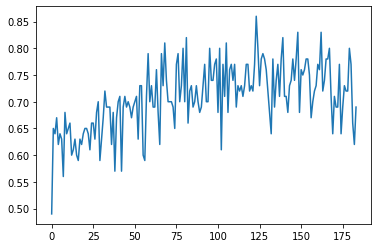

In [ ]:
plt.plot(df["val_acc"])